In [ ]:
uv add tensorboard

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torchvision import datasets
import torchvision.transforms as transforms

# SummaryWriter 인스턴스 생성
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

## 📘 PyTorch 이미지 전처리(Transforms) 강의 정리

## 1️⃣ 왜 이미지 전처리가 필요한가?

딥러닝 모델(CNN 등)은 다음 조건을 만족하는 데이터를 필요로 합니다.

- ✅ 숫자(Tensor) 형태
- ✅ 동일한 크기
- ✅ 안정적인 값의 분포

하지만 실제 이미지 데이터는:

- 다양한 크기
- 0~255 범위의 픽셀값
- PIL Image 또는 numpy 형태

따라서 **모델이 학습하기 좋은 형태로 변환하는 과정**이 필요합니다.  
이 과정을 **전처리(Preprocessing)** 라고 합니다.

---

## 2️⃣ 전체 코드

```python
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(32),
    transforms.Normalize((0.5,), (1.0,))
])

In [5]:
data_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize(32),
        transforms.Normalize((0.5,),(1.0,))  #간이 정규화    minist데이터셋 : mean = 0.1307 std  = 0.3081
    ]
)

train_data = datasets.MNIST(root='./',train=True,download=True,transform=data_transform)
test_data = datasets.MNIST(root='./',train=False,download=True,transform=data_transform)

In [6]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_data,batch_size=32,shuffle=True)
test_loader = DataLoader(test_data,batch_size=32)

In [48]:
next(iter(train_loader))[0].shape

torch.Size([32, 1, 32, 32])

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=6, kernel_size=5, stride=1)
        self.conv2 = nn.Conv2d(in_channels=6,out_channels=16, kernel_size=5, stride=1)
        self.conv3 = nn.Conv2d(in_channels=16,out_channels=120, kernel_size=5, stride=1)
        self.fc1 = nn.Linear(in_features=120, out_features=84)
        self.fc2 = nn.Linear(in_features=84, out_features=10)

    def forward(self,x):
        x = self.conv1(x)
        x = F.tanh(x)
        x = F.max_pool2d(x,2,2)
        x = self.conv2(x)
        x = F.tanh(x)
        x = F.max_pool2d(x,2,2)
        x = self.conv3(x)
        x = F.tanh(x)
        x = x.view(-1,120)
        x = self.fc1(x)
        x = F.tanh(x)
        x = self.fc2(x)
        x = F.tanh(x)
        return x

model = Net()
model

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=120, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=10, bias=True)
)

In [8]:
image = torch.randn((1,1,32,32))
model(image)

tensor([[ 0.0212, -0.1747, -0.0076,  0.0199, -0.0988, -0.0508,  0.0998, -0.1640,
          0.0853, -0.1174]], grad_fn=<TanhBackward0>)

In [9]:
x_train, y_train = train_data.data, train_data.targets
x_test,y_test = test_data.data, test_data.targets

x_train.shape

torch.Size([60000, 28, 28])

In [ ]:
!uv add torchsummary

In [16]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

from torchsummary import summary
summary(model, input_size=(1,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 60, 60]             156
            Conv2d-2           [-1, 16, 26, 26]           2,416
            Conv2d-3            [-1, 120, 9, 9]          48,120
            Linear-4                   [-1, 84]          10,164
            Linear-5                   [-1, 10]             850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forward/backward pass size (MB): 0.32
Params size (MB): 0.24
Estimated Total Size (MB): 0.57
----------------------------------------------------------------


In [49]:
image = torch.randn((1,1,32,32))
model(image)

tensor([[-1.0000, -1.0000, -0.8958, -0.0496, -0.9987, -1.0000, -0.9985, -1.0000,
          0.8337, -1.0000]], grad_fn=<TanhBackward0>)

In [18]:
optim = Adam(model.parameters(),lr=1e-3)

count = 0
for epoch in range(10):

    for data,label in train_loader:
        optim.zero_grad()
        pred = model(data.to(device))
        loss = nn.CrossEntropyLoss() (pred,label.to(device))
        # 저장하고 싶은 값 넣기
        writer.add_scalar("Loss/train", loss, count )
        count+=1
        loss.backward()
        optim.step()

    print(f'{epoch+1} loss:{loss.item()}')

1 loss:0.8104057908058167
2 loss:0.8168475031852722
3 loss:0.8044862747192383
4 loss:0.8236927390098572
5 loss:0.799309253692627
6 loss:0.7976731657981873
7 loss:0.7991207838058472
8 loss:0.8157407641410828
9 loss:0.8374765515327454
10 loss:0.796645998954773


## PyTorch `model.eval()` 완전 이해하기

### 1. 한 줄 핵심 정리
- `model.train()` → **학습 모드**
- `model.eval()` → **평가(추론) 모드**

딥러닝 모델은 **학습할 때와 예측할 때 동작이 달라지는 레이어**가 존재하기 때문에  
테스트/검증 전에 반드시 `model.eval()`을 사용해야 한다.

---

### 2. 왜 필요한가?

일부 레이어는 **Train 모드와 Eval 모드에서 동작이 다름**

대표적으로 매우 중요한 2가지:

### (1) Dropout
과적합 방지를 위해 학습 중 일부 뉴런을 랜덤으로 끔

| 모드 | 동작 |
|---|---|
| `train()` | 뉴런 일부 랜덤 OFF |
| `eval()` | 모든 뉴런 ON |

👉 예측할 때 랜덤으로 꺼지면 결과가 매번 달라짐

---

### (2) Batch Normalization
입력 데이터의 평균/분산을 정규화하는 레이어

| 모드 | 동작 |
|---|---|
| `train()` | 현재 배치의 평균/분산 사용 |
| `eval()` | 학습 중 저장된 평균/분산 사용 |

👉 평가 시 통계값이 고정되어야 안정적인 예측 가능

---

### 3. `eval()`을 안 쓰면 생기는 문제 😱

테스트할 때도 학습 모드로 동작하게 됨

- Dropout 계속 랜덤 작동
- BatchNorm 통계 계속 변함
- 예측 결과가 매번 달라짐
- 성능 평가가 틀어짐

👉 **테스트 정확도가 이상하게 낮아지는 원인 1순위**

---

### 4. 올바른 테스트 코드 (중요 ⭐)

```python
model.eval()          # 평가 모드 전환

with torch.no_grad(): # gradient 계산 OFF (속도↑ 메모리↓)
    for x, y in test_loader:
        pred = model(x)

In [19]:
model.eval()
with torch.no_grad():
    total_corr = 0

    for images,labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        preds = model(images)
        _, pred = torch.max(preds.data,1)
        total_corr += (pred == labels).sum().item()

    print(f'Acc {total_corr/len(test_data.targets)}')

Acc 0.9885


In [83]:
!tensorboard --logdir=runs

/Users/kimhanho/VSPRJ/wanted3/.venv/lib/python3.12/site-packages/tensorboard/default.py:30: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
TensorFlow installation not found - running with reduced feature set.
Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.20.0 at http://localhost:6006/ (Press CTRL+C to quit)


OSError: [Errno 5] Input/output error

In [84]:
#모델의 저장및 불러오기

import torch

# 모델 저장
torch.save(model.state_dict(), "model.pth")

In [85]:
import torch
import torch.nn as nn

# 1️⃣ 동일한 구조의 모델 먼저 생성
model = Net()  # 반드시 같은 클래스 구조여야 함

# 2️⃣ 가중치 로드
model.load_state_dict(torch.load("model.pth"))

# 3️⃣ 평가모드로 전환 (Dropout, BatchNorm 사용 시 필수)
model.eval()

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=120, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=10, bias=True)
)

In [103]:
img= test_data[10][0]
img.shape

torch.Size([1, 32, 32])

In [105]:
model(img.unsqueeze(0))

tensor([[ 1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000]], grad_fn=<TanhBackward0>)

In [106]:
import torch

# 모델 저장
torch.save(model, "model_all.pth")

In [50]:
from PIL import Image
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

In [51]:
model

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=120, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=10, bias=True)
)

In [75]:
target_layer = model.conv2

In [76]:
model.eval()

img, label = test_data[10]

input_tensor = img.unsqueeze(0).to(device)

output = model(input_tensor)
pred_class = output.argmax().item()

print("정답 :", label)
print("예측 :", pred_class)

정답 : 0
예측 : 0


In [77]:
cam=GradCAM(
model=model,
target_layers=[target_layer]
)

In [78]:
targets = [ClassifierOutputTarget(pred_class)]

In [79]:
grayscale_cam = cam(
    input_tensor=input_tensor,
    targets=targets
)

grayscale_cam = grayscale_cam[0]

In [80]:
grayscale_cam

array([[0.17615636, 0.17615636, 0.2000593 , ..., 0.34680003, 0.27906796,
        0.27906796],
       [0.17615636, 0.17615636, 0.2000593 , ..., 0.34680003, 0.27906796,
        0.27906796],
       [0.12890594, 0.12890594, 0.14544111, ..., 0.29472837, 0.236861  ,
        0.236861  ],
       ...,
       [0.03233261, 0.03233261, 0.05968606, ..., 0.12109371, 0.1684782 ,
        0.1684782 ],
       [0.        , 0.        , 0.        , ..., 0.1684782 , 0.23440447,
        0.23440447],
       [0.        , 0.        , 0.        , ..., 0.1684782 , 0.23440447,
        0.23440447]], shape=(32, 32), dtype=float32)

In [81]:
import numpy as np

img_np = img.squeeze().numpy()

# 정규화 복원
img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())

# 흑백 → RGB 변환
rgb_img = np.stack([img_np, img_np, img_np], axis=-1)

visualization = show_cam_on_image(
    rgb_img,
    grayscale_cam,
    use_rgb=True
)

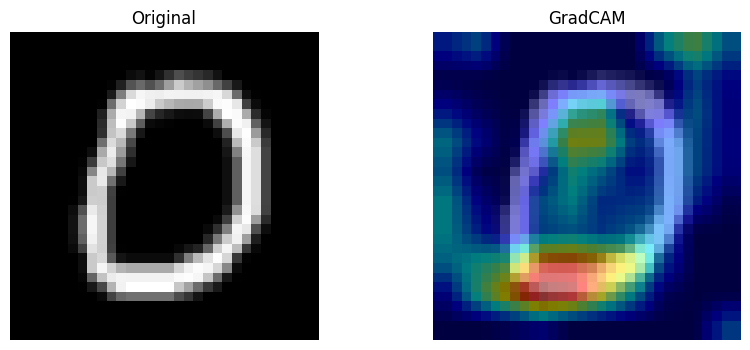

In [82]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.title("Original")
plt.imshow(img_np, cmap='gray')
plt.axis("off")

plt.subplot(1,2,2)
plt.title("GradCAM")
plt.imshow(visualization)
plt.axis("off")

plt.show()

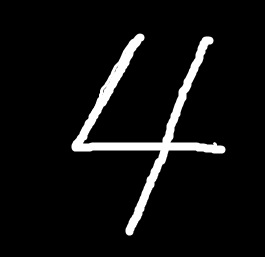

In [119]:
from PIL import Image
img = Image.open('data/4.png')
img

In [122]:
import numpy as np

img_np = np.array(img)
print(img_np.shape)

(257, 265, 3)


In [124]:

img_tensor = transforms.ToTensor()(img)

print(img_tensor.shape)

torch.Size([3, 257, 265])


In [ ]:
infer_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Grayscale(),
        transforms.Resize(32),
        transforms.Normalize((0.5,),(1.0,))
    ]
)
img = infer_transform(img)
img.size()



torch.Size([1, 32, 32])

In [117]:
pred = nn.Softmax()(model(img.unsqueeze(0)))
pred

tensor([[0.0610, 0.0610, 0.0610, 0.0610, 0.4509, 0.0610, 0.0610, 0.0610, 0.0610,
         0.0610]], grad_fn=<SoftmaxBackward0>)